# **COVID-19 _(2020-2021)_ Data Analysis**
# **&**
# **Future Cases Prediction**

## 1. Dependencies

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # this is to avoid errors in Prophet Model since we are using the newest version of pandas

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

## 2. Exploration and cleaning of the datasets.

### 2.1. Exploration of the dataset

In [6]:
df = pd.read_csv('../data/covid19-data.csv')
df

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests,Cases,Deaths
0,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-25,8.0,NaN,NaN
1,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-26,5.0,NaN,NaN
2,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-27,4.0,NaN,NaN
3,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-28,1.0,NaN,NaN
4,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-29,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38467,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-24,1804.0,35960.0,1456.0
38468,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-25,2965.0,35994.0,1458.0
38469,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-26,NaN,36044.0,1463.0
38470,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-27,NaN,36058.0,1463.0


In [7]:
df.Entity.unique()

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Bulgaria', 'Canada',
       'Cape Verde', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Ghana', 'Greece', 'Guatemala', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait',
       'Latvia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar',
       'Malawi', 'Malaysia', 'Malta', 'Mauritania', 'Mexico', 'Mongolia',
       'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal',
       'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama',
       'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia',

In [8]:
len(df.Entity.unique())

104

* __104__ Different Countries
---

In [9]:
df.Continent.unique()

array(['Europe', 'Africa', 'South America', 'Oceania', 'Asia',
       'North America'], dtype=object)

In [10]:
len(df.Continent.unique())

6

* __6__ Different Continents
---

In [11]:
df.shape

(38472, 15)

* __38472__ Rows

* __16__ Columns
---

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Entity                           38472 non-null  object 
 1   Continent                        38472 non-null  object 
 2   Latitude                         38472 non-null  float64
 3   Longitude                        38472 non-null  float64
 4   Average temperature per year     38472 non-null  int64  
 5   Hospital beds per 1000 people    38472 non-null  float64
 6   Medical doctors per 1000 people  38472 non-null  float64
 7   GDP/Capita                       38472 non-null  float64
 8   Population                       38472 non-null  int64  
 9   Median age                       38472 non-null  int64  
 10  Population aged 65 and over (%)  38472 non-null  int64  
 11  Date                             38472 non-null  object 
 12  Daily tests       

* The existence of NaN values in Cases, Deaths, and Daily Tests
---

In [13]:
df_range = pd.to_datetime(df['Date']).agg(['min', 'max'])

df_range

min   2020-01-01
max   2021-02-28
Name: Date, dtype: datetime64[ns]

* Date ranges from the 1st January 2020 to the 28th February of the year 2021
---

In [14]:
df.describe()

,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths
count,38472.000000,38472.000000,38472.000000,38472.000000,38472.000000,38472.000000,3.847200e+04,38472.000000,38472.000000,3.057700e+04,3.821800e+04,34862.000000
mean,23.737060,20.210847,17.717145,3.165305,2.086313,19002.331415,4.896983e+07,32.751508,10.663392,3.944059e+04,2.879027e+05,8090.504733
std,26.060413,61.074922,8.134926,2.561767,1.518252,22271.107786,1.427251e+08,8.472305,6.770417,1.501847e+05,1.405243e+06,29548.753221
min,-40.900000,-106.350000,-2.000000,0.200000,0.020000,411.600000,3.412840e+05,16.000000,1.000000,-2.391720e+05,1.000000e+00,1.000000
25%,8.620000,-3.440000,11.000000,1.400000,0.820000,3659.000000,4.793900e+06,27.000000,5.000000,1.505000e+03,2.074000e+03,77.000000
50%,27.510000,21.820000,20.000000,2.500000,1.890000,8821.800000,1.148464e+07,32.000000,8.000000,5.520000e+03,2.143100e+04,527.000000
75%,45.940000,47.480000,25.000000,4.490000,3.210000,25946.200000,4.286296e+07,41.000000,16.000000,2.038200e+04,1.373770e+05,3480.500000
max,64.960000,179.410000,29.000000,13.050000,7.520000,114704.600000,1.339180e+09,48.000000,28.000000,2.945871e+06,2.860567e+07,513091.000000


### 2.2 Data cleaning:
Imputing NaN values using interpolation

In [15]:


# forward fill for 'Daily tests' we aim to maintain temporal integrity
df['Daily tests'].fillna(method='ffill', inplace=True)

# interpolation for 'Cases' to account for gradual changes
df['Cases'].interpolate(method='linear', inplace=True)

# interpolation for 'Deaths', considering the larger number of missing values
df['Deaths'].interpolate(method='linear', inplace=True)

df.isna().sum()


Entity                              0
Continent                           0
Latitude                            0
Longitude                           0
Average temperature per year        0
Hospital beds per 1000 people       0
Medical doctors per 1000 people     0
GDP/Capita                          0
Population                          0
Median age                          0
Population aged 65 and over (%)     0
Date                                0
Daily tests                         0
Cases                              13
Deaths                             15
dtype: int64

In [16]:
# applying backward fill for the remaining missing values in 'Cases' and 'Deaths'
df['Cases'].fillna(method='bfill', inplace=True)
df['Deaths'].fillna(method='bfill', inplace=True)

df.isna().sum()


Entity                             0
Continent                          0
Latitude                           0
Longitude                          0
Average temperature per year       0
Hospital beds per 1000 people      0
Medical doctors per 1000 people    0
GDP/Capita                         0
Population                         0
Median age                         0
Population aged 65 and over (%)    0
Date                               0
Daily tests                        0
Cases                              0
Deaths                             0
dtype: int64

---
Dropping Duplicates

In [17]:
df = df.drop_duplicates()

---
Converting Date column to datetime format

In [18]:
df['Date'] = pd.to_datetime(df['Date'])

---
## 3. Exploratory Data Analysis (EDA) :
Poltting the correlation between our relevant features

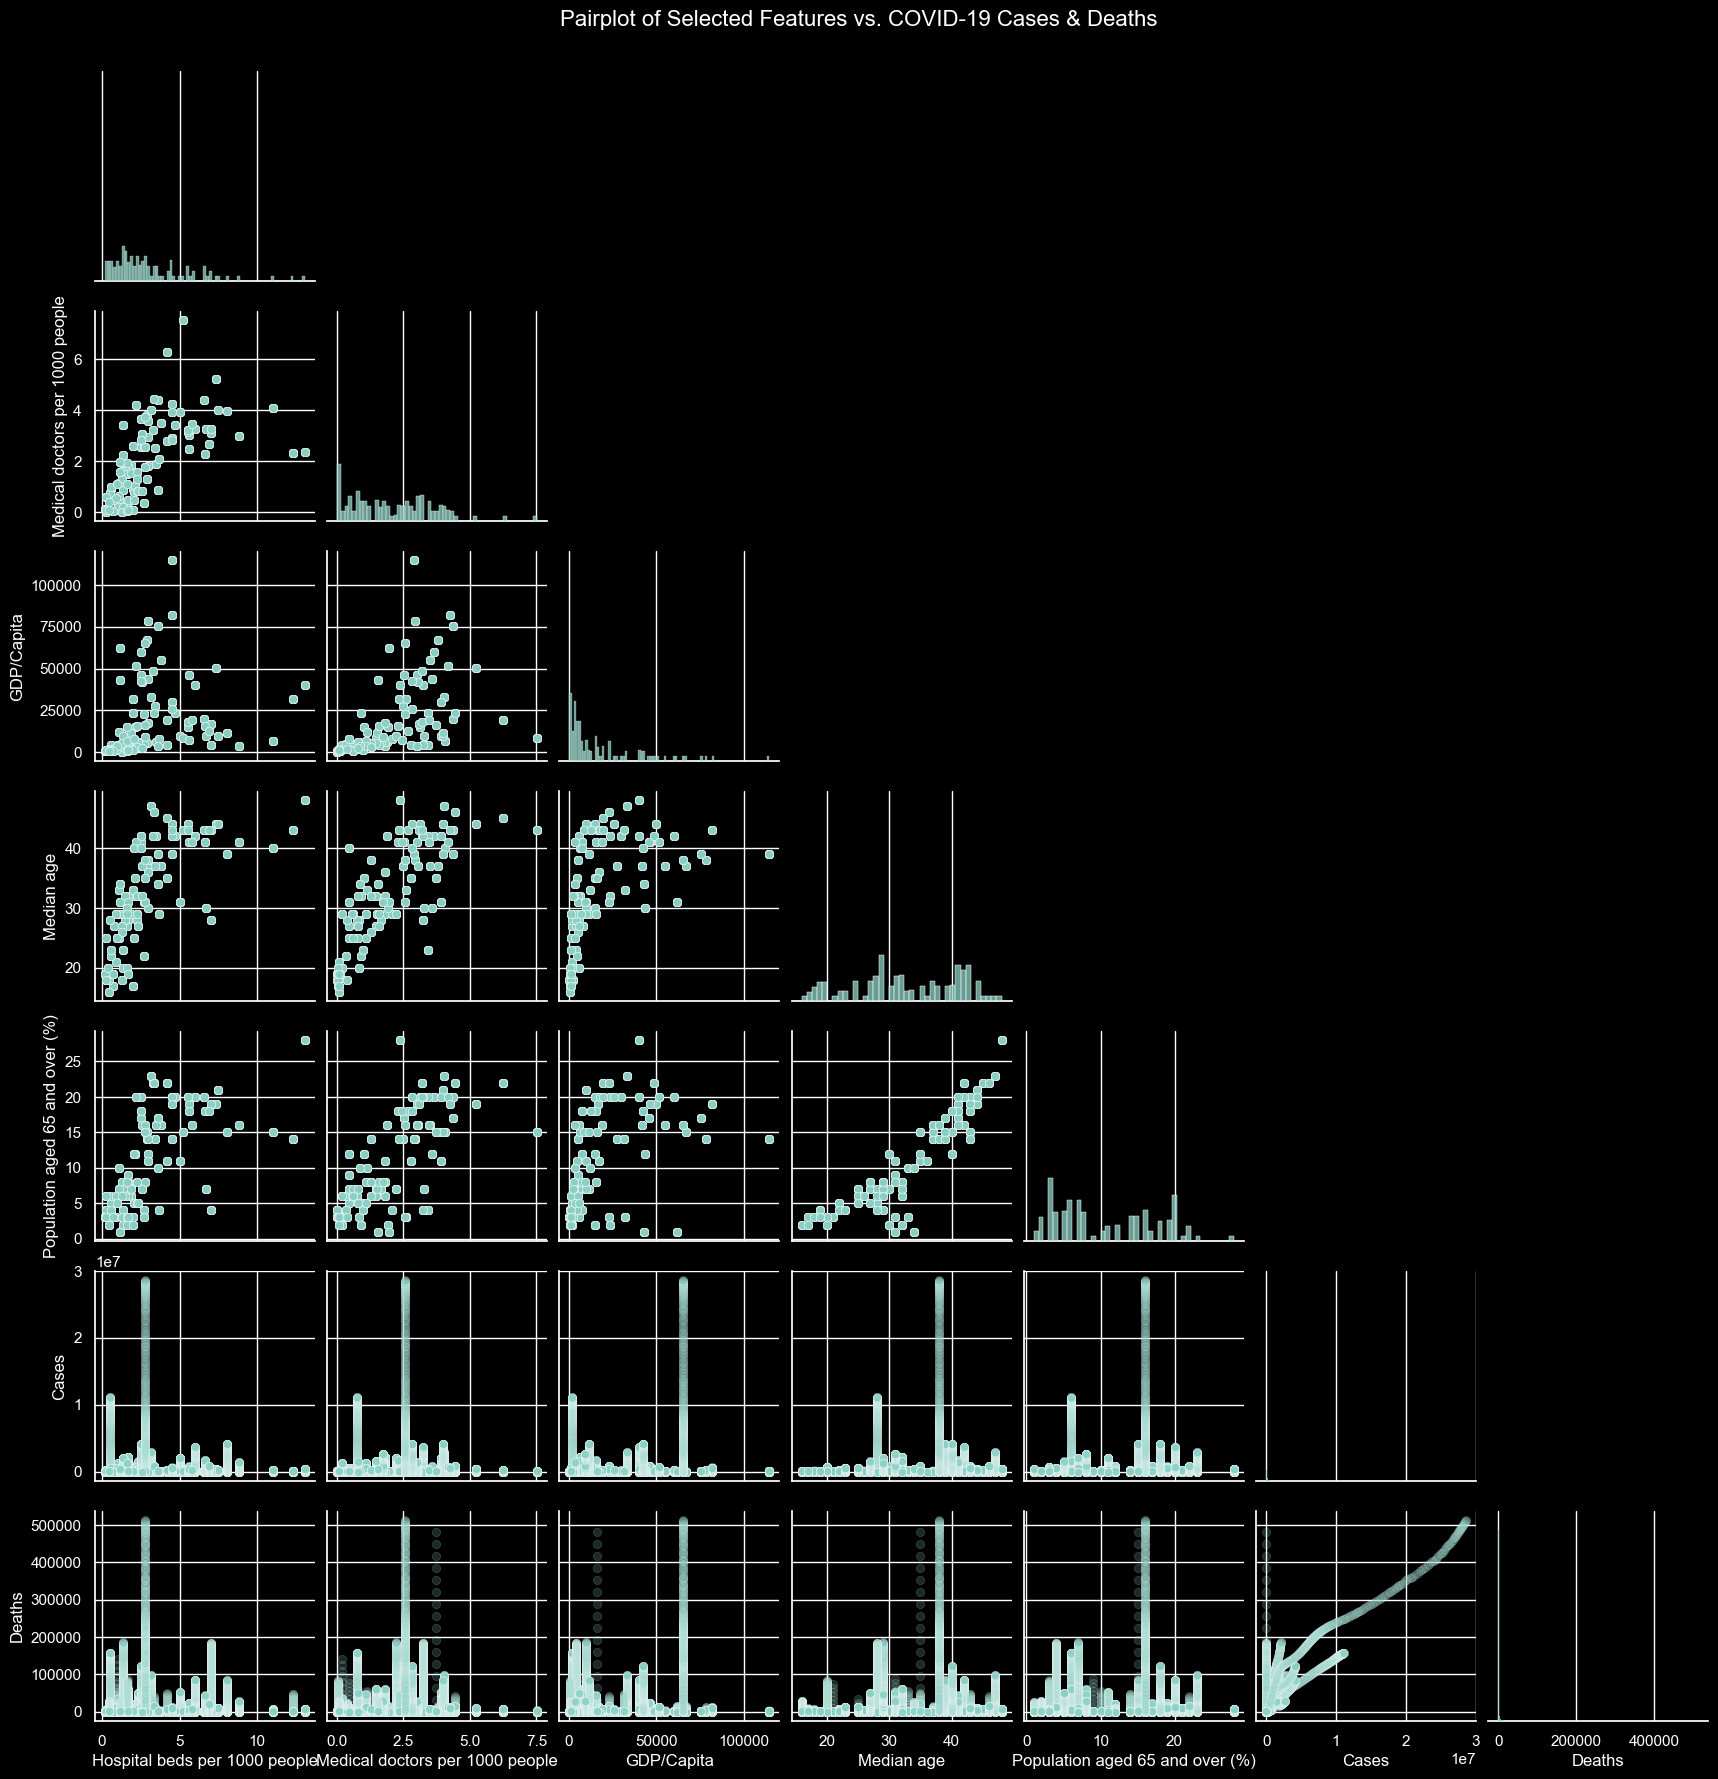

In [19]:
# we decided to select a subset of the dataframe for pairplot analysis to make it more interpretable
subset_df = df[['Hospital beds per 1000 people', 'Medical doctors per 1000 people', 'GDP/Capita', 'Median age', 'Population aged 65 and over (%)', 'Cases', 'Deaths']].dropna()

sns.set(style="darkgrid")
plt.style.use("dark_background")

# we did a pairplot to visualize the relationships between the selected features
sns.pairplot(subset_df, corner=True, plot_kws={'alpha':0.2}, palette='bright')
plt.suptitle('Pairplot of Selected Features vs. COVID-19 Cases & Deaths', size=16, y=1.02)
plt.show()

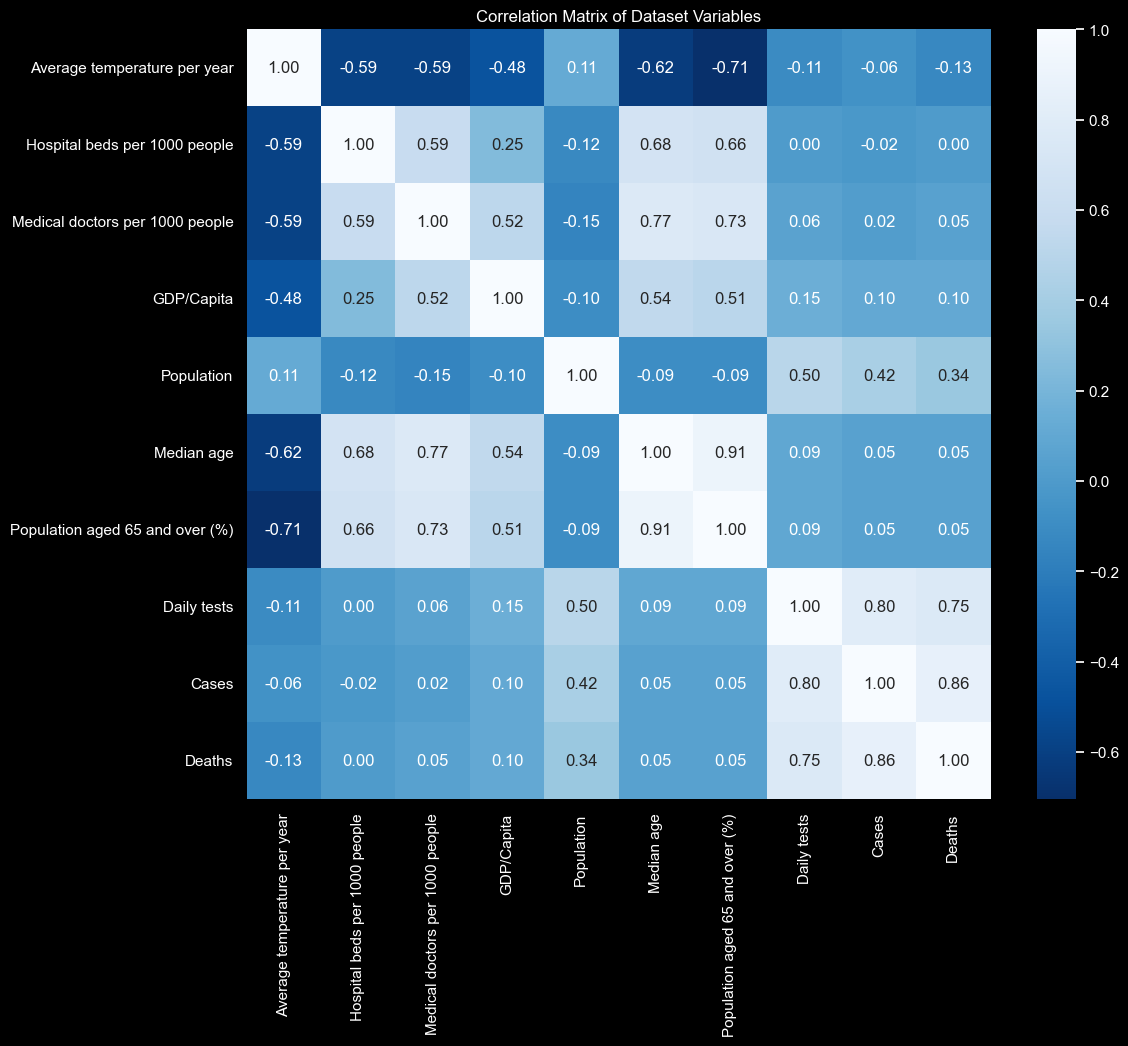

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['Average temperature per year', 'Hospital beds per 1000 people',
                                 'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
                                 'Median age', 'Population aged 65 and over (%)',
                                 'Daily tests', 'Cases', 'Deaths']].corr()



# styling the plot
sns.set(style="darkgrid")
plt.style.use("dark_background")

# correlation matrix's plot
plt.figure(figsize=(12, 10))
correlation_matrix_plot = sns.heatmap(correlation_matrix, annot=True, cmap="Blues_r", fmt=".2f")
plt.title('Correlation Matrix of Dataset Variables')
plt.show()


#### Strong correlations:
* __Cases and Deaths (0.86)__: This strong positive correlation indicates that as the number of COVID-19 cases increases, the number of deaths tends to increase as well, which is expected given the nature of the pandemic.

* __Daily Tests and Cases (0.80), Daily Tests and Deaths (0.75)__: These strong positive correlations suggest that regions with more extensive testing report higher numbers of cases and deaths. This may reflect both the spread of the virus and the level of response in terms of testing capacity.

* __Median Age and population Aged 65 and Over (0.91)__: A strong positive correlation shows that countries with a higher median age typically have a larger percentage of the population aged 65 and over. This relationship underscores demographic patterns related to aging populations.

#### Moderate to weak correlations:
* __GDP/Capita and Healthcare resources__: Moderate positive correlations with hospital beds (0.38) and medical doctors (0.43) per 1000 people suggest that wealthier countries tend to have better healthcare resources. However, the correlation isn't extremely strong, indicating other factors also play significant roles.

* __Population and COVID-19 metrics__: The population shows moderate positive correlations with Daily Tests (0.50), Cases (0.42), and Deaths (0.38). This indicates that larger populations tend to have higher absolute numbers of tests, cases, and deaths, but the relationship isn't perfectly linear, suggesting effective response measures can mitigate impacts regardless of population size

## **Trend Analysis of COVID-19 Cases and Deaths**

### 1. Monthly Cases and Deaths by Continent

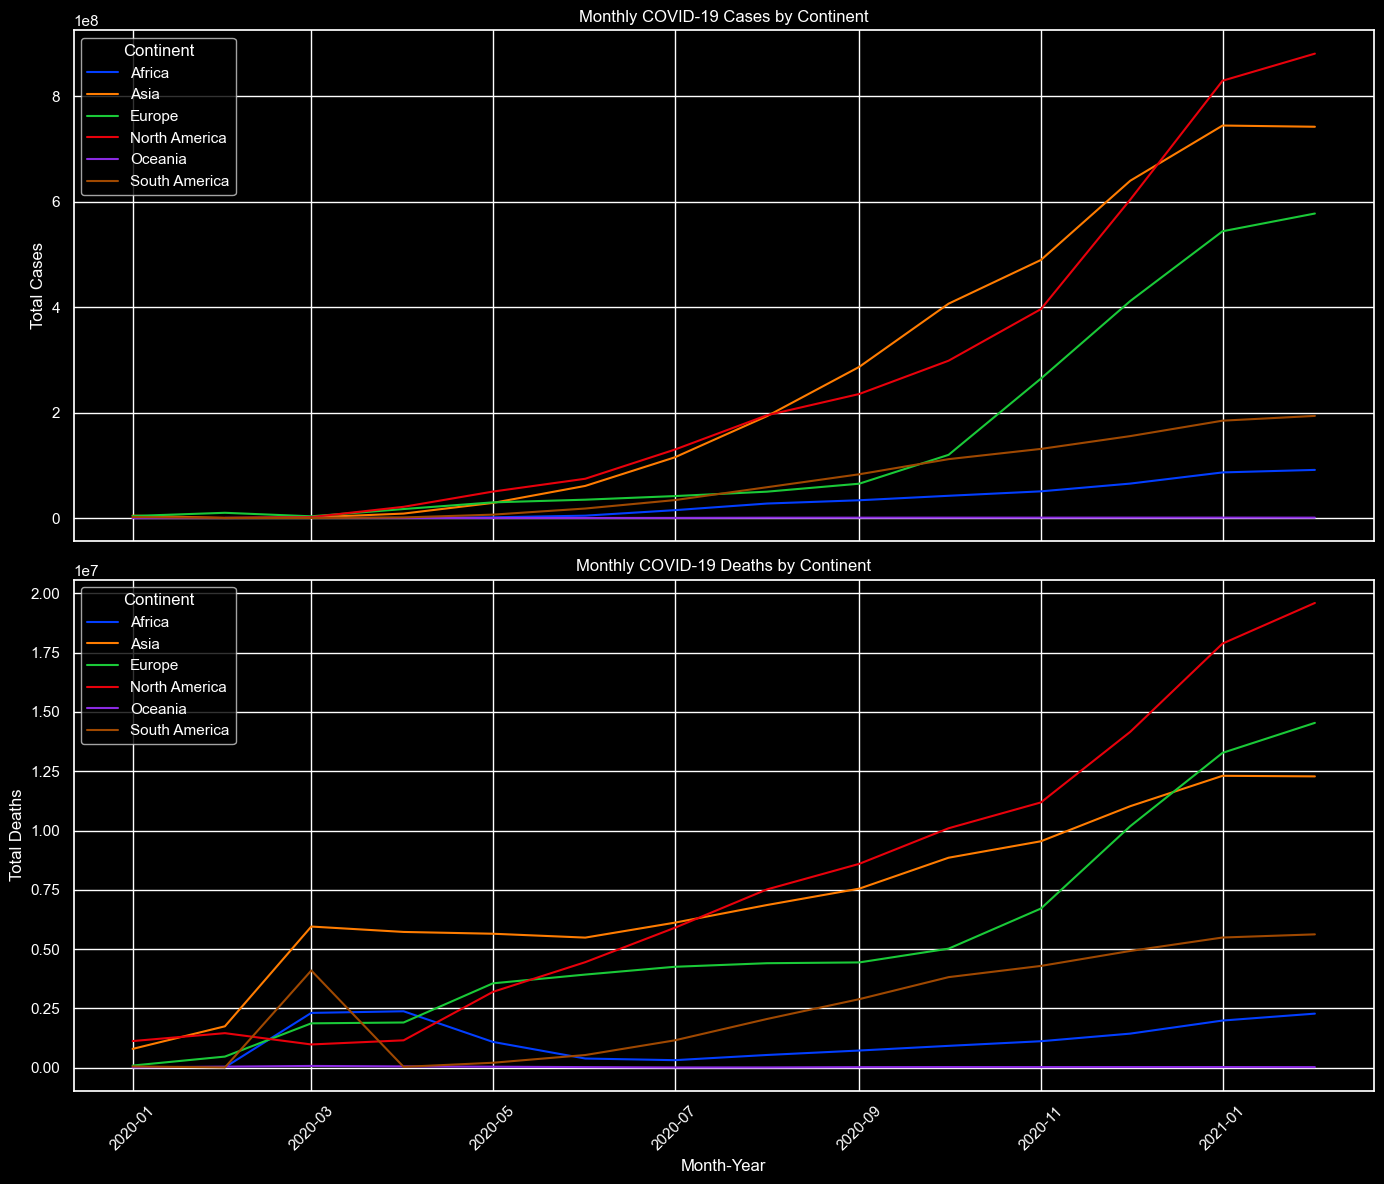

In [21]:
# 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# 'Month-Year' column for grouping the data by month
df['Month-Year'] = df['Date'].dt.to_period('M')

# grouping data by 'Continent' and 'Month-Year' and summing up cases and deaths
monthly_data = df.groupby(['Continent', 'Month-Year']).agg({'Cases':'sum', 'Deaths':'sum'}).reset_index()

# ensuring that 'Cases' and 'Deaths' are numeric
monthly_data['Cases'] = pd.to_numeric(monthly_data['Cases'], errors='coerce')
monthly_data['Deaths'] = pd.to_numeric(monthly_data['Deaths'], errors='coerce')

# we had to correct 'Month-Year' for plotting purposes by converting it back to datetime (the first day of each month)
monthly_data['Month-Year'] = monthly_data['Month-Year'].dt.to_timestamp()

# replotting with corrected data types
fig, ax = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# plotting cases
sns.lineplot(data=monthly_data, x='Month-Year', y='Cases', hue='Continent', ax=ax[0], palette='bright')
ax[0].set_title('Monthly COVID-19 Cases by Continent')
ax[0].set_ylabel('Total Cases')
ax[0].tick_params(axis='x', rotation=45)

# plotting deaths
sns.lineplot(data=monthly_data, x='Month-Year', y='Deaths', hue='Continent', ax=ax[1], palette='bright')
ax[1].set_title('Monthly COVID-19 Deaths by Continent')
ax[1].set_ylabel('Total Deaths')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 2. Monthly Cases and Deaths Globally

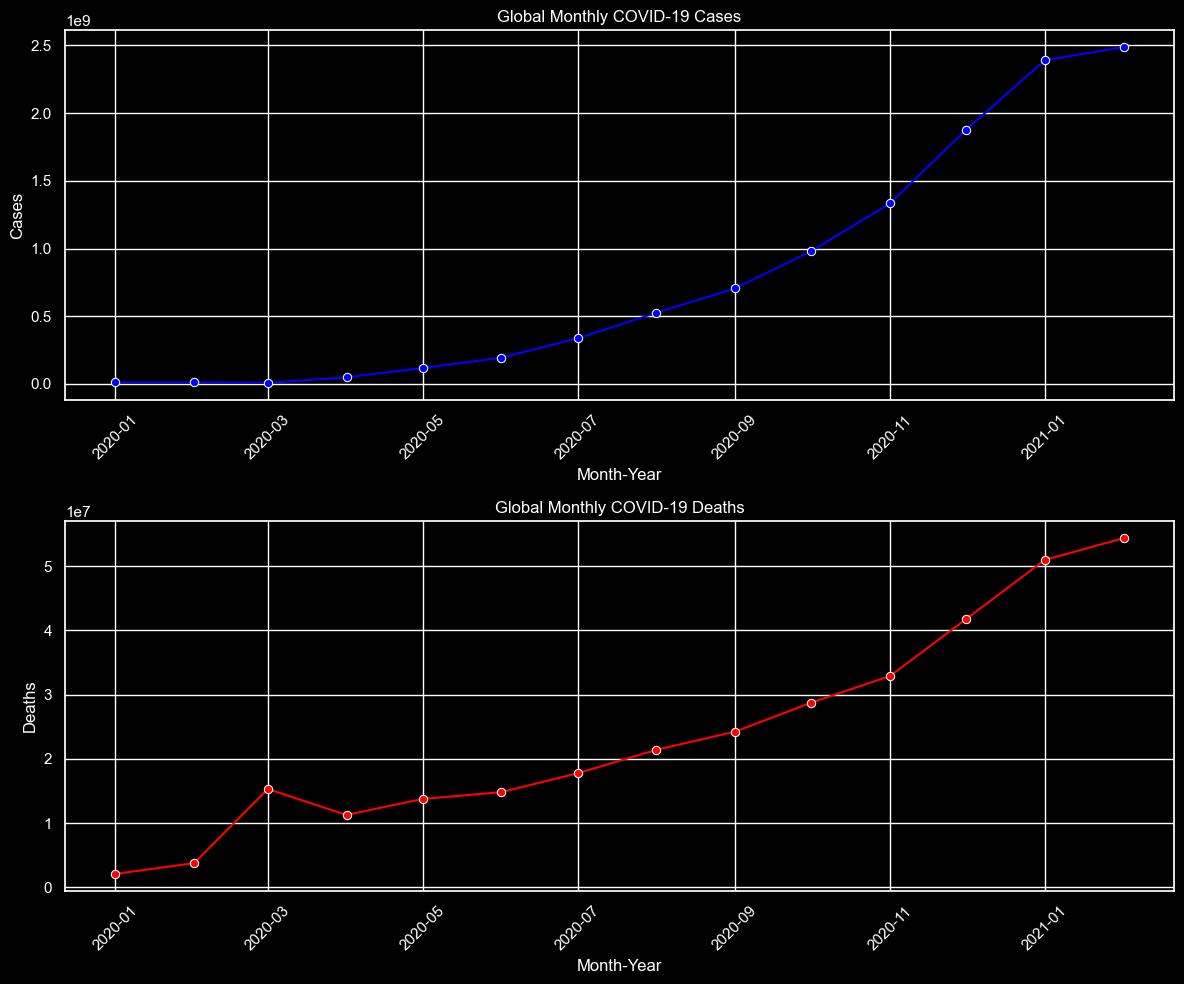

In [22]:
# aggregating global monthly data for cases and deaths
global_monthly_data = df.groupby('Month-Year').agg({'Cases':'sum', 'Deaths':'sum'}).reset_index()

# 'Month-Year' to a datetime format for the plotting
global_monthly_data['Month-Year'] = global_monthly_data['Month-Year'].dt.to_timestamp()

# global trends plot
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sns.lineplot(data=global_monthly_data, x='Month-Year', y='Cases', ax=ax[0], color='blue', marker='o')
ax[0].set_title('Global Monthly COVID-19 Cases')
ax[0].set_ylabel('Cases')
ax[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=global_monthly_data, x='Month-Year', y='Deaths', ax=ax[1], color='red', marker='o')
ax[1].set_title('Global Monthly COVID-19 Deaths')
ax[1].set_ylabel('Deaths')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### __Understanding the peak that occurred between 2020-02 & 2020-04__

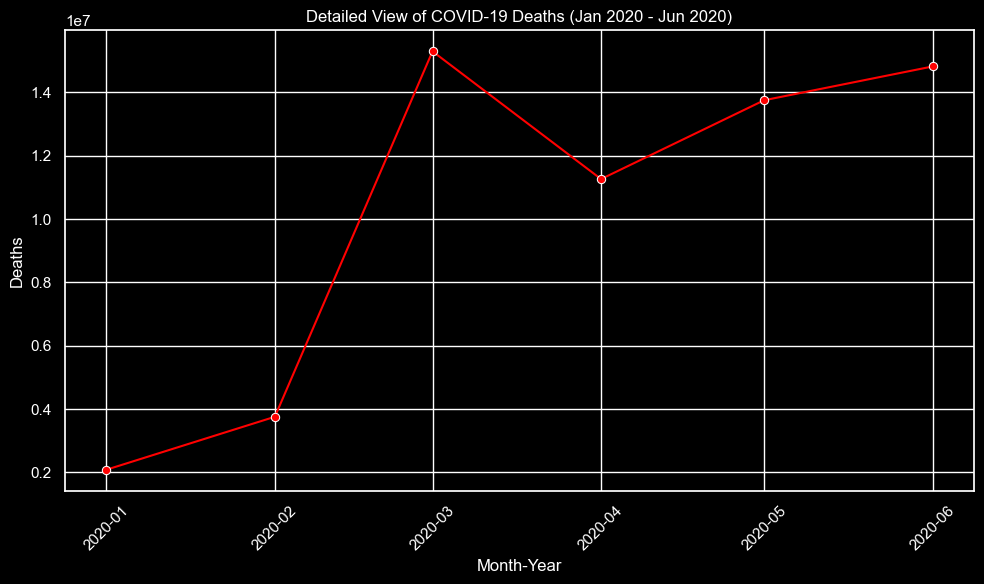

In [23]:
# in this plot we're gonna focus on the period around the initial peak for a closer examination of the deaths
# here we isolated the data around March 2020 for a detailed view
focused_period_deaths = global_monthly_data[(global_monthly_data['Month-Year'] >= '2020-01') & (global_monthly_data['Month-Year'] <= '2020-06')]


# plotting the focused period for deaths
plt.figure(figsize=(10, 6))
sns.lineplot(data=focused_period_deaths, x='Month-Year', y='Deaths', color='red', marker='o')
plt.title('Detailed View of COVID-19 Deaths (Jan 2020 - Jun 2020)')
plt.ylabel('Deaths')
plt.xlabel('Month-Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### ___Conclusions___
* __Global Awareness__: March 2020 is when many governments and populations began to realize the severity of the pandemic, leading to lockdowns and emergency health measures.

* __Lag Effect__: There's typically a lag between case detection, hospitalizations, and deaths, which means the actions (or inactions) in early 2020 began to show their consequences around this time.

* __Rapid Spread__: In the early stages of the pandemic COVID-19 was spreading rapidly across continents, leading to increased fatalities.



_source:_

https://www.who.int/data/stories/the-true-death-toll-of-covid-19-estimating-global-excess-mortality

https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_March_2020

https://ourworldindata.org/covid-deaths

# Top 10 Countries with the highest Cases & Deaths

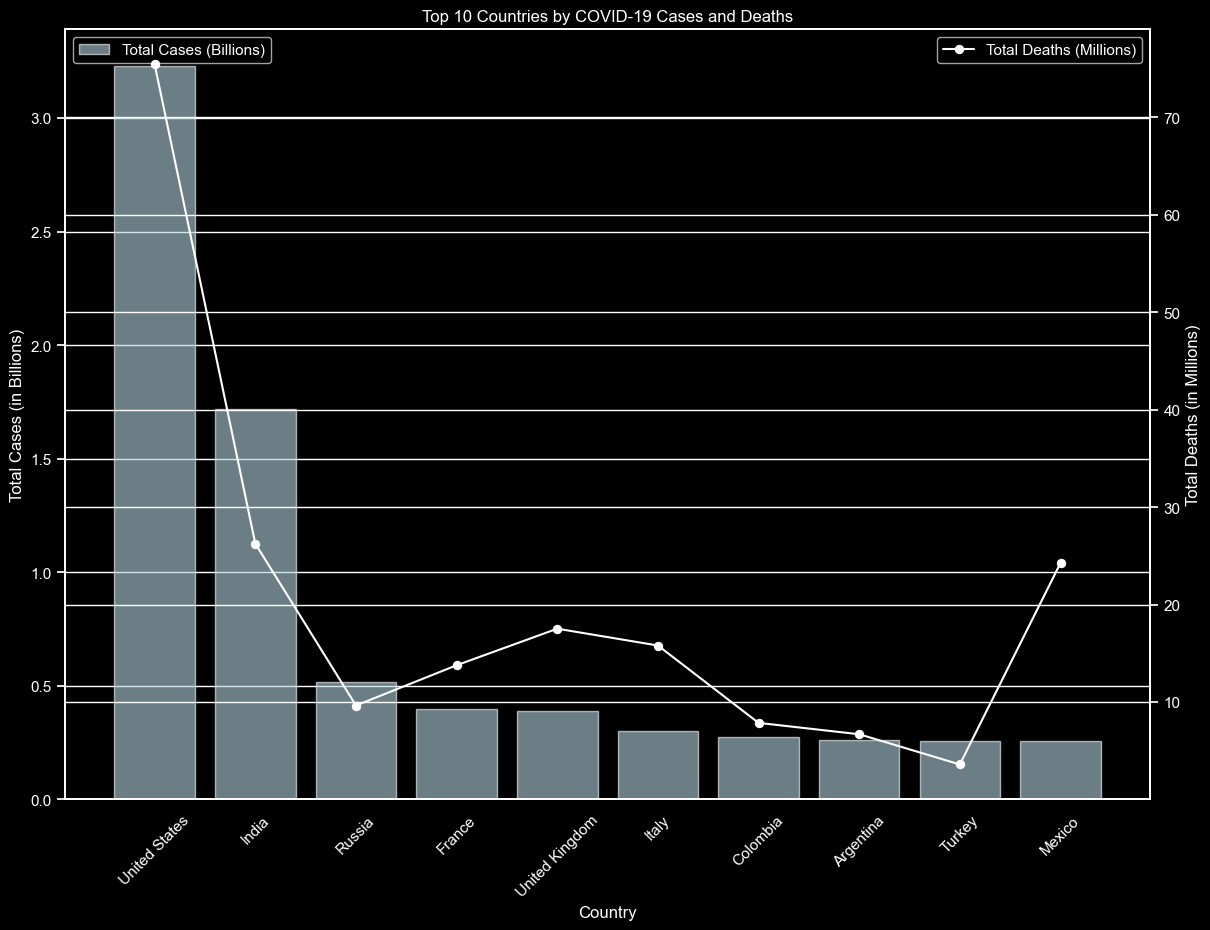

In [24]:
# preparing the dataset

# summing up cases and deaths for each country. Also this part groups the DataFrame by the 'Entity' column

country_aggregates = df.groupby('Entity').agg(    # this allowed us to apply one or more operations to the grouped data
    Total_Cases=('Cases', 'sum'),                 # this creates a new column Total_Cases in the resulting DataFrame by summing up all the values in the 'Cases' column for each country.
    Total_Deaths=('Deaths', 'sum'),               # this creates a new column Total_Deaths by summing up all the values in the 'Deaths' column for each country.
    Population=('Population', 'mean')             # we calculate the mean of the 'Population' column for each country. 
).reset_index()


## Why we assumed population is constant and used the mean:
## Using the mean simplifies calculations. Instead of adjusting the population for each entry (which could vary day to day with births, deaths, migration, etc.), taking the average provides a single, stable figure to work with.
## When comparing across countries, using an average ensures us that the same metric (population) is used consistently for all countries, which makes the comparisons fair and the calculations simpler





# he we combined top cases and deaths into one dataframe for plotting
top_cases_and_deaths = country_aggregates.nlargest(10, 'Total_Cases')

## we found "nlargest" method in pandas to select the top n rows with the highest values in a certain column



# 1e6 = 1,000,000 (1 Million)
# 1e9 = 1,000,000,000 (1 Billion)
top_cases_and_deaths['Total_Deaths_in_Millions'] = top_cases_and_deaths['Total_Deaths'] / 1e6
top_cases_and_deaths['Total_Cases_in_Billions'] = top_cases_and_deaths['Total_Cases'] / 1e9

# plotting
plt.figure(figsize=(14, 10))

# creating a bar plot for the cases
bar = sns.barplot(x='Entity', y='Total_Cases_in_Billions', data=top_cases_and_deaths,
                  color='lightblue', alpha=0.6, label='Total Cases (Billions)')

# creating a line plot for the deaths, using a secondary y-axis
line = bar.twinx()
sns.lineplot(x='Entity', y='Total_Deaths_in_Millions', data=top_cases_and_deaths, 
             color='white', marker='o', label='Total Deaths (Millions)', ax=line)

bar.set_title('Top 10 Countries by COVID-19 Cases and Deaths')
bar.set_xlabel('Country')
bar.set_ylabel('Total Cases (in Billions)')
line.set_ylabel('Total Deaths (in Millions)')
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar.legend(loc='upper left')
line.legend(loc='upper right')

plt.show()


**Note** : _(The bar chart represents total cases, while the line chart with markers indicates total deaths for these countries)_

#### _**Key Insights**_:
* **Correlation Between Cases and Deaths**: There's a clear visual correlation between the number of reported cases and deaths across these countries. Higher case counts generally correlate with higher death tolls, underscoring the deadly nature of the virus, especially in contexts with overwhelmed healthcare systems or high-risk populations.

* **Variation in Death Rates**: While all top countries have high case numbers, there's noticeable variation in the death rates. Some countries have higher deaths relative to their case counts, which could point to varying levels of healthcare capacity, differences in population demographics, or the effectiveness of the countries' response strategies.

* **Response Measures**: Indirectly, the plot also offers insights into the effectiveness of different countries' response measures. Countries with lower death rates despite high case counts may have had more effective healthcare responses or mitigation strategies.



# Global distribution of COVID-19 Deaths & Cases

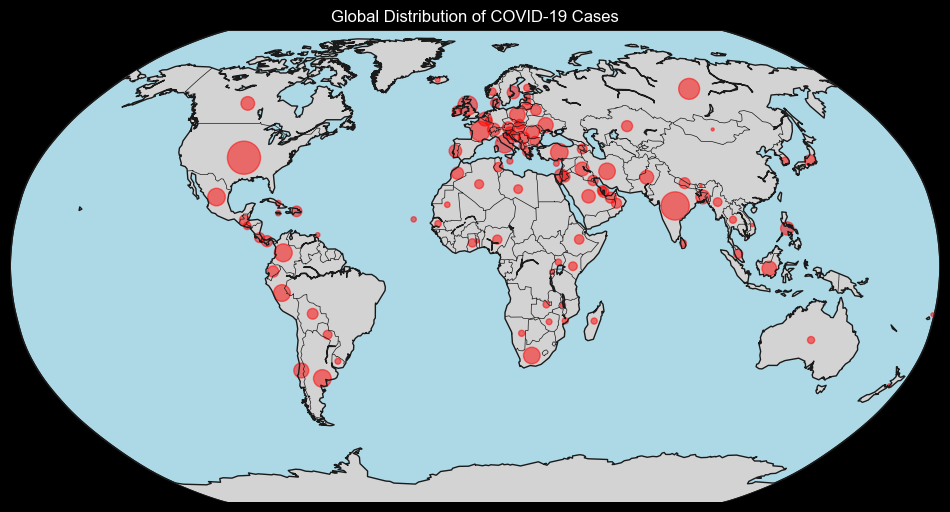

In [25]:
# aggregating total COVID-19 cases by country for the latest available data point
country_cases = df.groupby(['Entity', 'Latitude', 'Longitude'])['Cases'].sum().reset_index()

# Basemap setting for cases
plt.figure(figsize=(12, 8))
m = Basemap(projection='robin', lat_0=0, lon_0=0)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# converting the latitude and longitude to x and y coordinates
x, y = m(country_cases['Longitude'].values, country_cases['Latitude'].values)

# plot
scatter = m.scatter(x, y, s=np.sqrt(country_cases['Cases']) / 100, c='red', alpha=0.5)

plt.title('Global Distribution of COVID-19 Cases')
plt.show()


 __Note :__ _(The red dots indicate the number of deaths and cases that occurred in each country. They don't indicate the area or zone of spreading)_

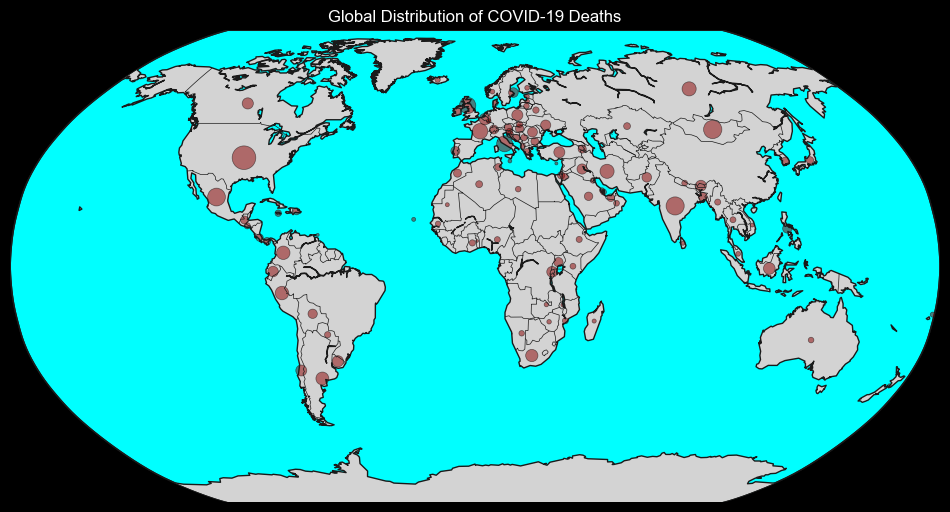

In [26]:
# aggregating total COVID-19 deaths by country for the latest available data point
country_deaths = df.groupby(['Entity', 'Latitude', 'Longitude'])['Deaths'].sum().reset_index()

# Basemap setting for deaths
plt.figure(figsize=(12, 8))
m = Basemap(projection='robin', lat_0=0, lon_0=0)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# converting the latitude and longitude to x and y coordinates for plotting deaths
x, y = m(country_deaths['Longitude'].values, country_deaths['Latitude'].values)

# plot
scatter = m.scatter(x, y, s=np.sqrt(country_deaths['Deaths']) / 30, c='darkred', alpha=0.5, edgecolors='black', linewidth=0.5)

plt.title('Global Distribution of COVID-19 Deaths')
plt.show()


In [27]:
# total deaths and cases by continent
continent_deaths = df.groupby('Continent')['Deaths'].sum().reset_index()
continent_cases = df.groupby('Continent')['Cases'].sum().reset_index()


display(continent_deaths)
continent_cases

,Continent,Deaths
0,Africa,15524181.0
1,Asia,99912029.5
2,Europe,74671176.0
3,North America,107315770.5
4,Oceania,457566.5
5,South America,35201964.0


,Continent,Cases
0,Africa,4.206555e+08
1,Asia,3.723511e+09
2,Europe,2.175135e+09
3,North America,3.719593e+09
4,Oceania,7.884048e+06
5,South America,9.817798e+08


## Total Cases

* __Africa__: 420,655,500 cases
* __Asia__: 3,723,511,000 cases
* __Europe__: 2,175,135,000 cases
* __North America__: 3,719,593,000 cases
* __Oceania__: 7,884,048 cases
* __South America__: 981,779,800 cases

## Total Deaths

* __Africa__: 15,524,181 deaths
* __Asia__: 99,912,029 deaths
* __Europe__: 74,671,176 deaths
* __North America__: 107,315,770 deaths
* __Oceania__: 457,566 deaths
* __South America__: 35,201,964 deaths


---
# Data preprocessing steps

### 1. Check daily records for each country:
   Determine if each country has a record for every day


In [28]:
def count_records_by_country(df):
    country_counts = df.groupby('Entity')['Date'].nunique()
    country_counts.dropna(inplace=True)
    return country_counts.info()

### 2. Filtering out countries with incomplete records:
   Countries that do not have daily records will be dropped from the analysis to maintain consistency and data integrity

In [29]:
count_records_by_country(df)

<class 'pandas.core.series.Series'>
Index: 104 entries, Albania to Zimbabwe
Series name: Date
Non-Null Count  Dtype
--------------  -----
104 non-null    int64
dtypes: int64(1)
memory usage: 1.6+ KB


**Insights:**  No country will be dropped since they all have daily records

### 3. Isolating countries by continent:
Separate the dataset by continent to handle geographical differences.

In [30]:
df_continents = {continent: data for continent, data in df.groupby('Continent')}
df_continents.keys()

dict_keys(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'])

In [31]:
# we splitted separate dataframes for each continent
df_continents = {continent: df[df['Continent'] == continent] for continent in df['Continent'].unique()}

# aggregating dataframe for each continent by date as index, including the mean
df_aggregated = {continent: df.groupby('Date').agg({
    'Cases': 'mean',
    'Deaths': 'mean',
    'Average temperature per year': 'mean',
    'Hospital beds per 1000 people': 'mean',
    'Medical doctors per 1000 people': 'mean',
    'GDP/Capita': 'mean',
    'Population': 'mean',
    'Median age': 'mean',
    'Population aged 65 and over (%)': 'mean'
}).reset_index() for continent, df in df_continents.items()}
for continent, df in df_aggregated.items():
    df_aggregated[continent] = df.set_index('Date')



---
# **_Final Step: Machine Learning (ML)_**
__Predicting next month's COVID-19 cases for each of the selected a continents__


---
* ### First: Data splitting
    - Splitting the data into train and test sets, using time-series split (TSCV) for each of selected Continents.

* ### Second: Model selection
    - For time-series prediction, models like ARIMA, Prophet, XGB could be suitable. For comparing reasons, we will use LinearRegression.

* ### Third: Model Training and validation
    * Training model on the train set and validate its performance on the training and testing set using (MAE , MSE , RMSE , R2).


### **Europe Dataset**

In [32]:

df_europe = df_aggregated['Europe']
df_europe.head()

,Cases,Deaths,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%)
Date,,,,,,,,,
2020-01-24,318053.758065,6607.578804,10.5,5.255,3.745,61243.8,37792332.5,42.5,19.5
2020-01-25,307452.516129,6431.157609,10.5,5.255,3.745,61243.8,37792332.5,42.5,19.5
2020-01-26,3.000000,645.347826,13.0,5.980,3.240,40493.9,67118648.0,42.0,20.0
2020-01-27,296850.774194,6238.627717,10.5,5.255,3.745,61243.8,37792332.5,42.5,19.5
2020-01-28,286249.532258,6062.206522,10.5,5.255,3.745,61243.8,37792332.5,42.5,19.5


Train MAE: 12170.045968509296
Test MAE: 21503.427770077997
Train MSE: 245875911.58515698
Test MSE: 484436634.3126339
Train RMSE: 15680.430848199197
Test RMSE: 22009.921270023522
Train R2: 0.9358023272368563
Test R2: -14.411838190416425
Train MAE: 7384.2447601490985
Test MAE: 69227.32264324448
Train MSE: 157705503.8814872
Test MSE: 8895799047.056341
Train RMSE: 12558.085199642786
Test RMSE: 94317.54368650798
Train R2: 0.9191401647584185
Test R2: -0.7206236497221259
Train MAE: 29755.026306341395
Test MAE: 143513.89739422937
Train MSE: 1451219777.7626164
Test MSE: 20770007404.328667
Train RMSE: 38094.87862905743
Test RMSE: 144118.0328908519
Train R2: 0.6679973200309809
Test R2: -0.7588749786671738


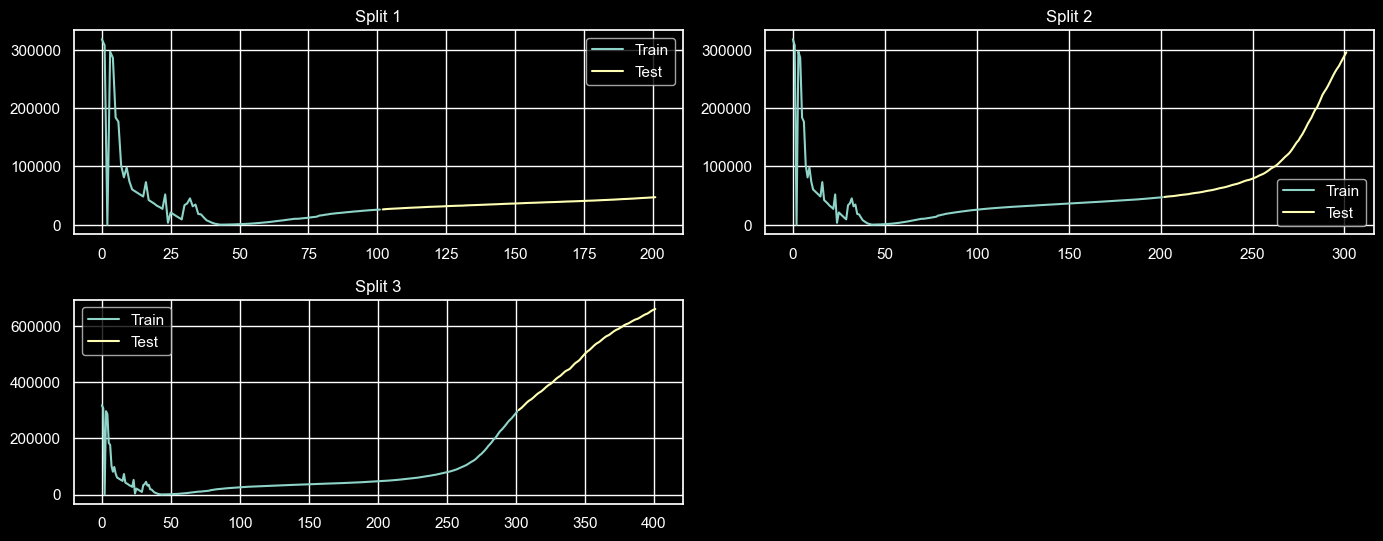

In [33]:
def train_and_evaluate_for_europe(df_europe):
    # we definine our target and explanatory variables
    X = df_europe.drop(['Cases'], axis=1).values
    y = df_europe['Cases'].values

    # instantiating TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)

    # splitting the data
    train_indices = []
    test_indices = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_indices.append(train_index)
        test_indices.append(test_index)

        # model training
        model = LinearRegression()
        model.fit(X_train, y_train)

        # predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # evaluation
        print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
        print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

        print("Train MSE:", mean_squared_error(y_train, y_pred_train))
        print("Test MSE:", mean_squared_error(y_test, y_pred_test))

        print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
        print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
        
        print("Train R2:", r2_score(y_train, y_pred_train))
        print("Test R2:", r2_score(y_test, y_pred_test))
        
    # visualizing the splits
    plt.figure(figsize=(14, 8))
    for i, (train_index, test_index) in enumerate(zip(train_indices, test_indices), start=1):
        plt.subplot(3, 2, i)
        plt.plot(train_index, y[train_index], label="Train")
        plt.plot(test_index, y[test_index], label="Test")
        plt.title(f"Split {i}")
        plt.legend()
    plt.tight_layout()
    plt.show()

train_and_evaluate_for_europe(df_europe)

---
### **Asia Dataset**

In [34]:
df_asia = df_aggregated['Asia']
df_asia.head()

,Cases,Deaths,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%)
Date,,,,,,,,,
2020-01-04,524102.666667,9791.175439,27.0,2.1,0.47,7806.7,69037513.0,40.0,12.0
2020-01-05,493273.333333,9616.350877,27.0,2.1,0.47,7806.7,69037513.0,40.0,12.0
2020-01-06,462444.000000,9441.526316,27.0,2.1,0.47,7806.7,69037513.0,40.0,12.0
2020-01-08,431614.666667,9266.701754,27.0,2.1,0.47,7806.7,69037513.0,40.0,12.0
2020-01-09,400785.333333,9091.877193,27.0,2.1,0.47,7806.7,69037513.0,40.0,12.0


Train MAE: 29772.55171693707
Test MAE: 76546.9262849094
Train MSE: 3398740115.1905603
Test MSE: 7876058682.241745
Train RMSE: 58298.71452434059
Test RMSE: 88747.16154470376
Train R2: 0.7549210610461295
Test R2: -2.458527471679529
Train MAE: 43795.89405800854
Test MAE: 292908.0904791413
Train MSE: 3531975670.3475027
Test MSE: 97284875686.20421
Train RMSE: 59430.427142563116
Test RMSE: 311905.23510547914
Train R2: 0.5745043006799364
Test R2: -5.673323543084409
Train MAE: 67258.7934329169
Test MAE: 90899.79794045967
Train MSE: 8523635637.423522
Test MSE: 8957900100.47763
Train RMSE: 92323.53782987046
Test RMSE: 94646.18376077099
Train R2: 0.7390622617562091
Test R2: 0.35643116116178397


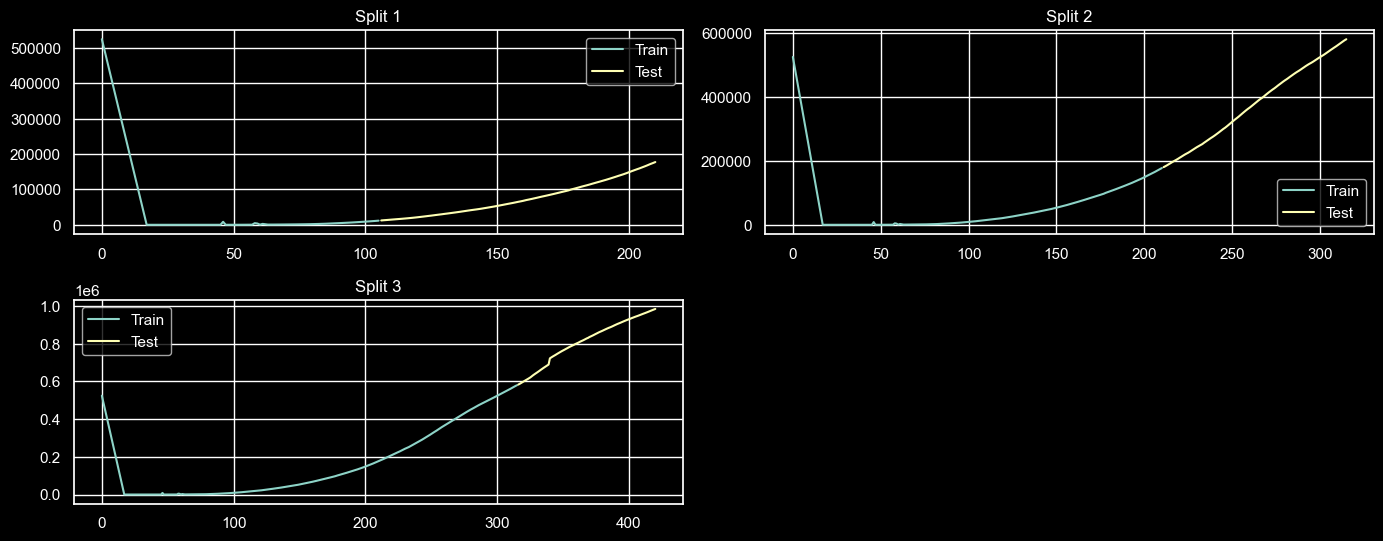

In [35]:
def train_and_evaluate_for_asia(df_asia):
    # we define our target and explanatory variables
    X = df_asia.drop(['Cases'], axis=1).values
    y = df_asia['Cases'].values

    # instantiating TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)

    # splitting the data
    train_indices = []
    test_indices = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_indices.append(train_index)
        test_indices.append(test_index)

        # model training
        model = LinearRegression()
        model.fit(X_train, y_train)

        # predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # evaluation
        print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
        print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

        print("Train MSE:", mean_squared_error(y_train, y_pred_train))
        print("Test MSE:", mean_squared_error(y_test, y_pred_test))

        print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
        print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
        
        print("Train R2:", r2_score(y_train, y_pred_train))
        print("Test R2:", r2_score(y_test, y_pred_test))
    
    # visualizing the splits
    plt.figure(figsize=(14, 8))
    for i, (train_index, test_index) in enumerate(zip(train_indices, test_indices), start=1):
        plt.subplot(3, 2, i)
        plt.plot(train_index, y[train_index], label="Train")
        plt.plot(test_index, y[test_index], label="Test")
        plt.title(f"Split {i}")
        plt.legend()
    plt.tight_layout()
    plt.show()


train_and_evaluate_for_asia(df_asia)

---
### **North America Dataset**

In [36]:
df_north_america = df_aggregated['North America']
df_north_america.head()

,Cases,Deaths,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%)
Date,,,,,,,,,
2020-01-01,16915.372881,435.430380,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0
2020-01-02,16623.745763,429.860759,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0
2020-01-03,16332.118644,424.291139,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0
2020-01-04,16040.491525,418.721519,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0
2020-01-05,15748.864407,413.151899,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0


Train MAE: 6448.694827025837
Test MAE: 202339.86791657118
Train MSE: 133884775.31424057
Test MSE: 53582061845.0874
Train RMSE: 11570.85888403452
Test RMSE: 231477.994299863
Train R2: 0.49633103386353195
Test R2: -3.2090453640128063
Train MAE: 56639.8377973317
Test MAE: 399558.14046190714
Train MSE: 6012362783.882464
Test MSE: 177448539612.50598
Train RMSE: 77539.42728626814
Test RMSE: 421246.4119876939
Train R2: 0.6702085156837316
Test R2: -4.827068595984956
Train MAE: 83985.77877166083
Test MAE: 854503.9645332211
Train MSE: 16324832160.474297
Test MSE: 811490907510.66
Train RMSE: 127768.66658329927
Test RMSE: 900827.9011612929
Train R2: 0.8579808868615116
Test R2: -1.4845874861213568


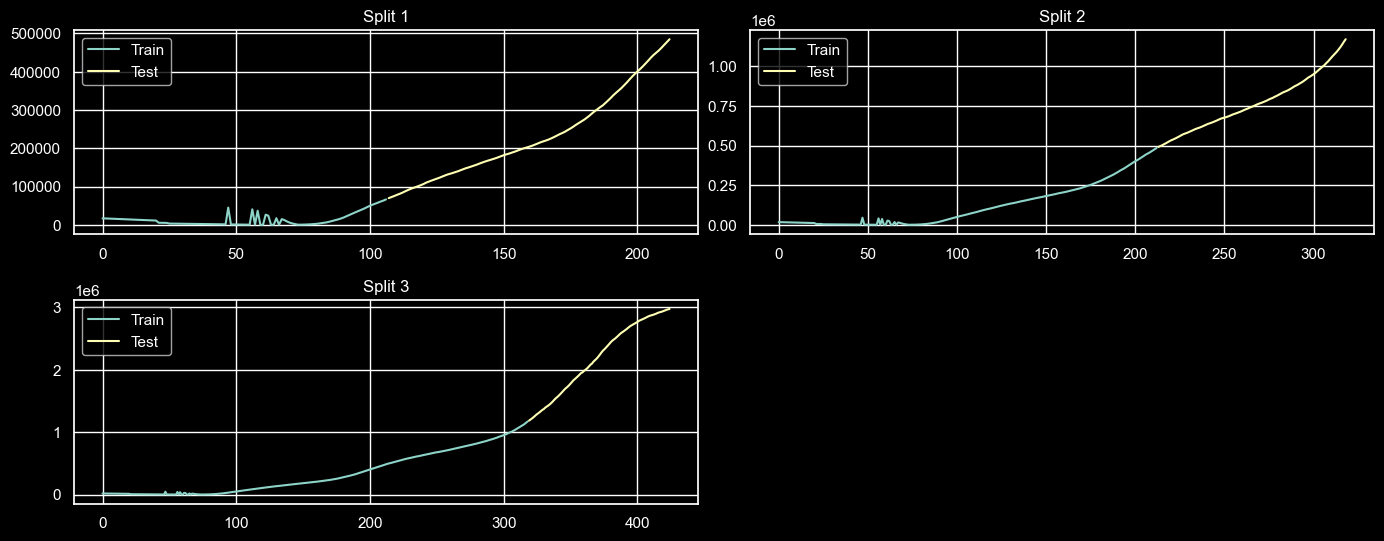

In [37]:
def train_and_evaluate_for_north_america(df_north_america):
    # we define our target and explanatory variables
    X = df_north_america.drop(['Cases'], axis=1).values
    y = df_north_america['Cases'].values

    # instantiating TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)

    # splitting the data
    train_indices = []
    test_indices = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_indices.append(train_index)
        test_indices.append(test_index)

        # model training
        model = LinearRegression()
        model.fit(X_train, y_train)

        # predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # evaluation
        print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
        print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

        print("Train MSE:", mean_squared_error(y_train, y_pred_train))
        print("Test MSE:", mean_squared_error(y_test, y_pred_test))

        print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
        print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
        
        print("Train R2:", r2_score(y_train, y_pred_train))
        print("Test R2:", r2_score(y_test, y_pred_test))
    
    # visualizing the splits
    plt.figure(figsize=(14, 8))
    for i, (train_index, test_index) in enumerate(zip(train_indices, test_indices), start=1):
        plt.subplot(3, 2, i)
        plt.plot(train_index, y[train_index], label="Train")
        plt.plot(test_index, y[test_index], label="Test")
        plt.title(f"Split {i}")
        plt.legend()
    plt.tight_layout()
    plt.show()

train_and_evaluate_for_north_america(df_north_america)


**Insights:** The LinearRegression performs bad on our data since the nature of the model is not meant to predict time-series tasks

**Potential Solutions:** Using more complex models that captures time-series like ARIMA, SARIMAX, Prophet

---
# **_Using more complex model_**: Prophet by Facebook

In [38]:
#pip install prophet


In [39]:
from prophet import Prophet

In [40]:
def predict_cases_continents(df_dict, n_splits=3):
    predictions = {}                                            # dictionaries
    scores_train = {}
    scores_test = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for continent, df in df_dict.items():
        df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Cases': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
        scores_train[continent] = []
        scores_test[continent] = []

        for train_idx, test_idx in tscv.split(df_prophet):
            train = df_prophet.iloc[train_idx]
            test = df_prophet.iloc[test_idx]
            
            # here we train the model
            model = Prophet(daily_seasonality='auto', yearly_seasonality='auto', weekly_seasonality='auto')
            model.fit(train)

            # predictions on the training set
            forecast_train = model.predict(train[['ds']])
            
            # predictions on the test set
            forecast_test = model.predict(test[['ds']])
            
            # storing the predictions
            predictions[continent] = {
                'train': forecast_train,
                'test': forecast_test
            }

            # we calculate scores for train set
            y_true_train = train['y']
            y_pred_train = forecast_train['yhat']
            scores_train[continent].append({
                'R2 Score': r2_score(y_true_train, y_pred_train),
                'MSE': mean_squared_error(y_true_train, y_pred_train),
                'MAE': mean_absolute_error(y_true_train, y_pred_train)
            })

            # we calculate scores for test set
            y_true_test = test['y']
            y_pred_test = forecast_test['yhat']
            scores_test[continent].append({
                'R2 Score': r2_score(y_true_test, y_pred_test),
                'MSE': mean_squared_error(y_true_test, y_pred_test),
                'MAE': mean_absolute_error(y_true_test, y_pred_test)
            })

    return predictions, scores_train, scores_test

# dictionary of continent dataframes we created before
df_continents = {
    'Europe': df_europe,
    'North America': df_north_america,
    'Asia': df_asia,
}

# displaying the predictions for all continents and evaluation scores
continent_predictions, evaluation_scores_train, evaluation_scores_test = predict_cases_continents(df_continents)

continent_predictions, evaluation_scores_train, evaluation_scores_test


12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing
12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:19 - cmdstanpy - INFO - Chain [1] done processing
12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:20 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing
12:40:22 - cmdstanpy - INFO - Chain [1] start processing
12:40:22 - cmdstanpy - INFO - Chain [1] done processing
12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1] done processing
12:40:23 - cmdstanpy - INFO - Chain [1] start processing
12:40:23 - cmdstanpy - INFO - Chain [1]

({'Europe': {'train':             ds          trend     yhat_lower     yhat_upper    trend_lower  \
   0   2020-01-24   94903.742815   56944.232911  138588.206424   94903.742815   
   1   2020-01-25   93398.101684   52402.823572  136020.514281   93398.101684   
   2   2020-01-26   91892.460553   48581.355665  128733.421853   91892.460553   
   3   2020-01-27   90386.819422   51619.034453  132375.982152   90386.819422   
   4   2020-01-28   88881.178291   50640.930019  129974.853128   88881.178291   
   ..         ...            ...            ...            ...            ...   
   297 2020-11-16  216391.599797  176452.437184  259341.792653  216391.599797   
   298 2020-11-17  218812.868323  181336.530036  259834.006789  218812.868323   
   299 2020-11-18  221234.136849  182363.489923  261425.462906  221234.136849   
   300 2020-11-19  223655.405375  182884.094068  264679.580892  223655.405375   
   301 2020-11-20  226076.673900  186790.213853  268630.732935  226076.673900   
   
     

* __trend:__ The underlying trend of the time series data, which is the model's long-term progression.

* __yhat_lower and yhat_upper:__ These are the lower and upper bounds of the forecast's confidence interval. They represent the range within which the actual value is expected to fall, with a certain level of confidence (typically 95%).

* __trend_lower and trend_upper:__ Similar to yhat_lower and yhat_upper, but specifically for the trend component of the model. They provide the confidence interval for the trend estimate.

* __additive_terms:__ Components of the model that are added together to make the final prediction. This could include weekly, yearly, or daily seasonality, as well as holiday effects, depending on the model configuration.

* __additive_terms_lower and additive_terms_upper:__ The lower and upper bounds of the confidence interval for the additive terms.

* __weekly, weekly_lower, weekly_upper:__ The weekly seasonality effect estimated by the model. The "_lower" and "_upper" refer to the lower and upper bounds of the confidence interval for the weekly component.

* __multiplicative_terms:__ Components that are multiplied by the trend to make the final prediction. This is used when the effect of seasonality grows or shrinks in proportion to the trend.

* __multiplicative_terms_lower and multiplicative_terms_upper:__ The confidence intervals for the multiplicative terms.

* __yhat:__ The final forecasted value (the 'hat' symbol ^ typically denotes an estimate or prediction). It's the sum of the trend, seasonality, and any other factors the model includes.


 __yhat__ is the final prediction, while __trend__ is just one component of that prediction.

### __Statistical Insights:__

In [41]:
# this are the predictions for the beginning and end of March for each continent
europe_begin_march = 231834.836757  # yhat at the start of March for Europe
europe_end_march = 234421.820829  # yhat at the end of March for Europe

north_america_begin_march = 1060856  # yhat at the start of March for North America
north_america_end_march = 1087474  # yhat at the end of March for North America

asia_begin_march = 589849.874801  # yhat at the start of March for Asia
asia_end_march = 1009208  # yhat at the end of March for Asia

# here we calculated the percentage increase for each continent
europe_increase = ((europe_end_march - europe_begin_march) / europe_begin_march) * 100
north_america_increase = ((north_america_end_march - north_america_begin_march) / north_america_begin_march) * 100
asia_increase = ((asia_end_march - asia_begin_march) / asia_begin_march) * 100

europe_increase, north_america_increase, asia_increase


(1.1158737436477526, 2.50910585414043, 71.09573861323281)

* __Europe:__ An increase of approximately __1.12%__
* __North America:__ An increase of approximately __2.51%__
* __Asia:__ A significant increase of approximately __71.10%__

### __Plotting the predictions__

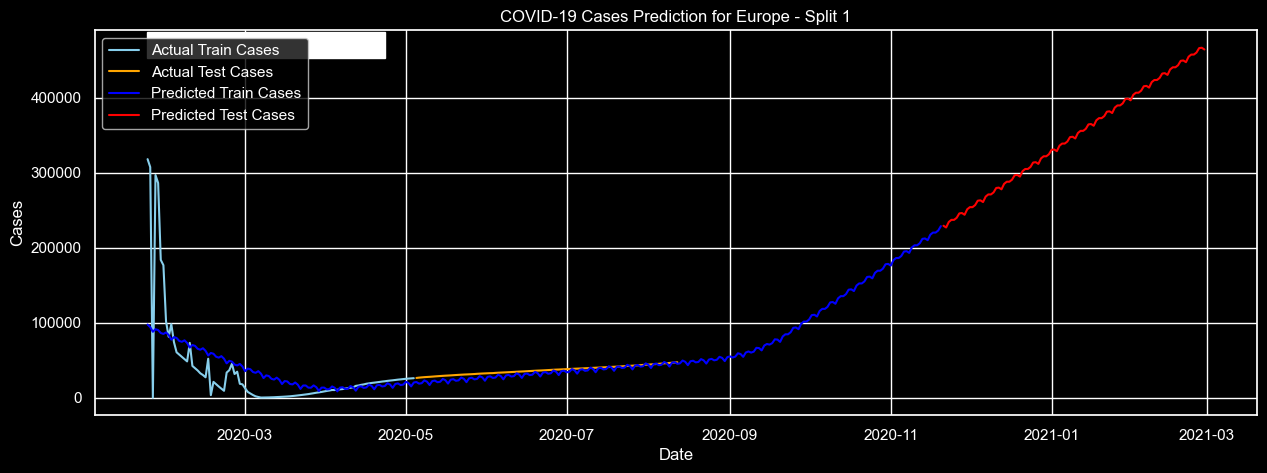

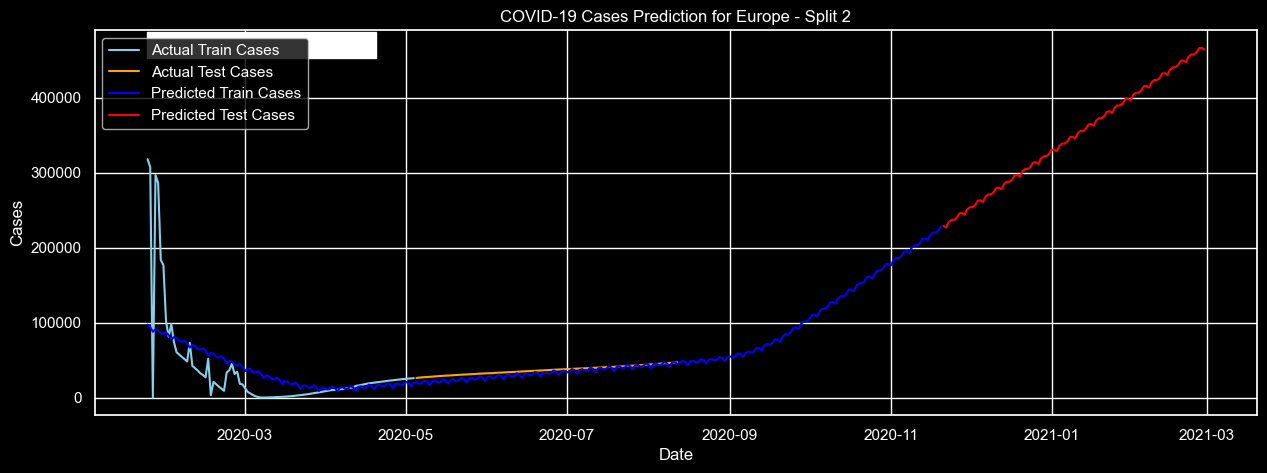

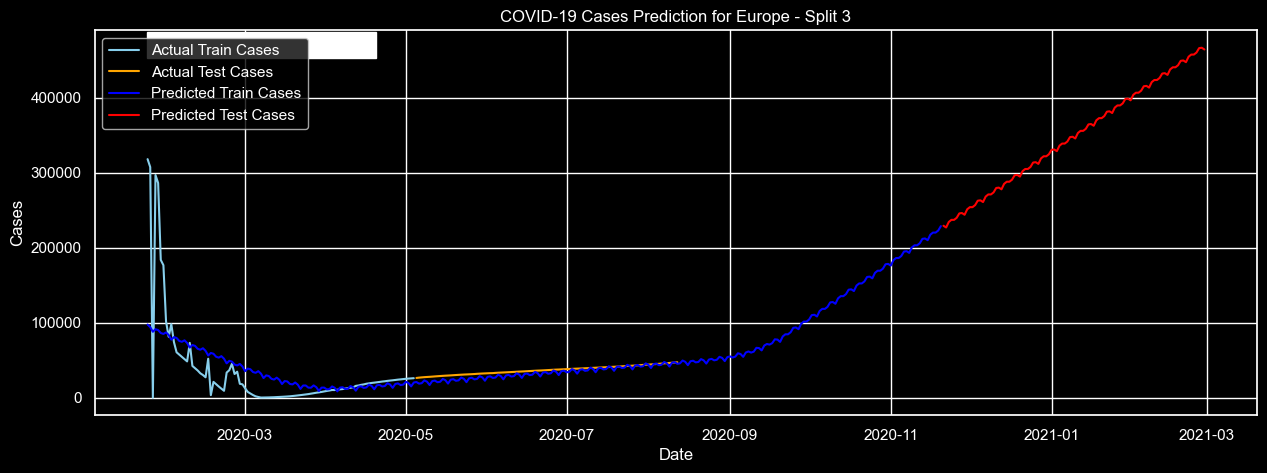

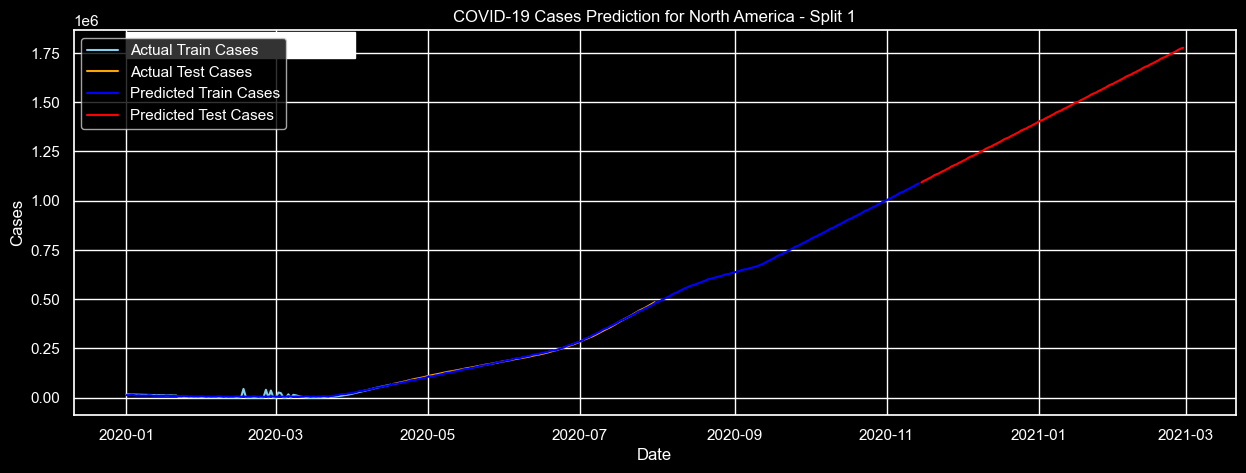

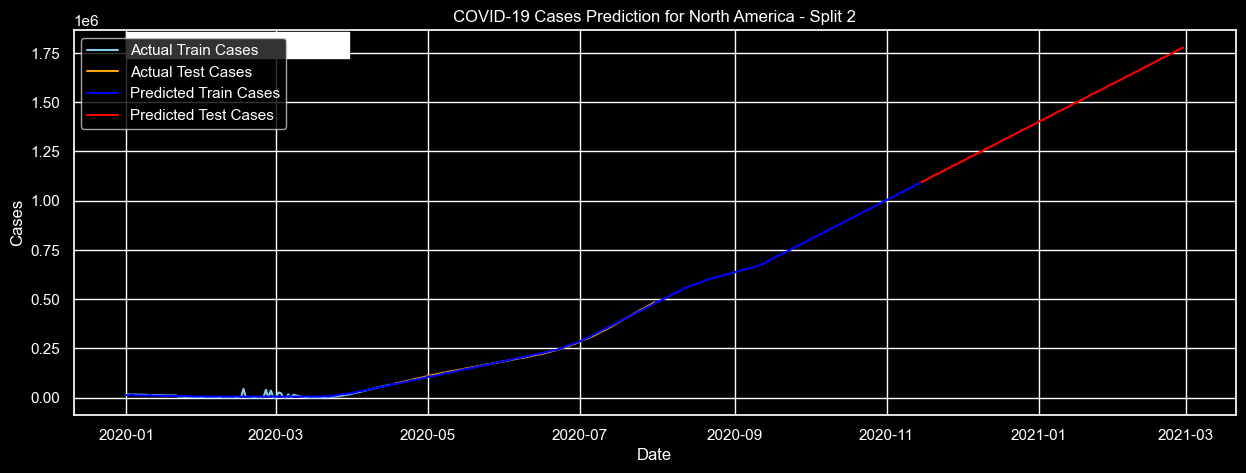

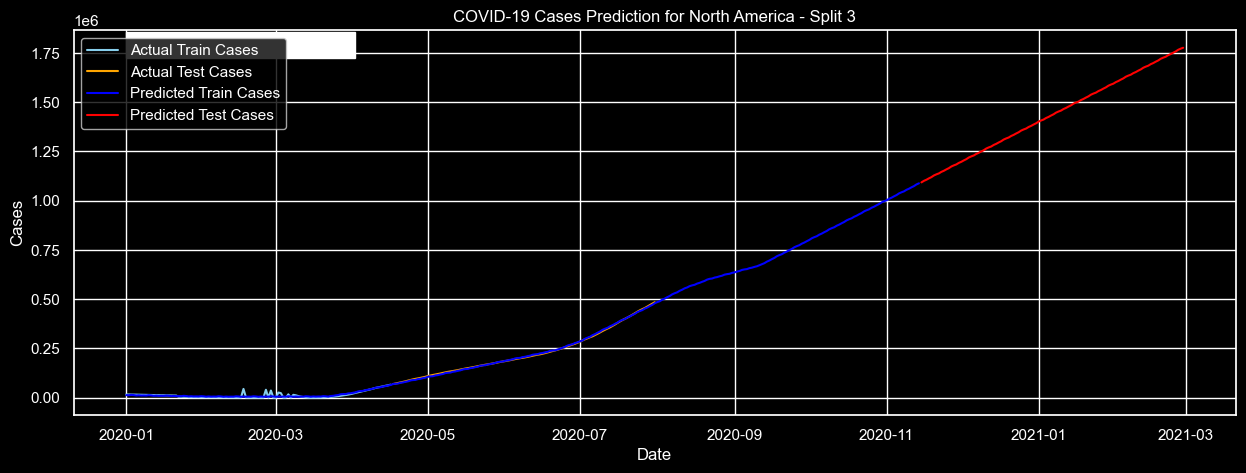

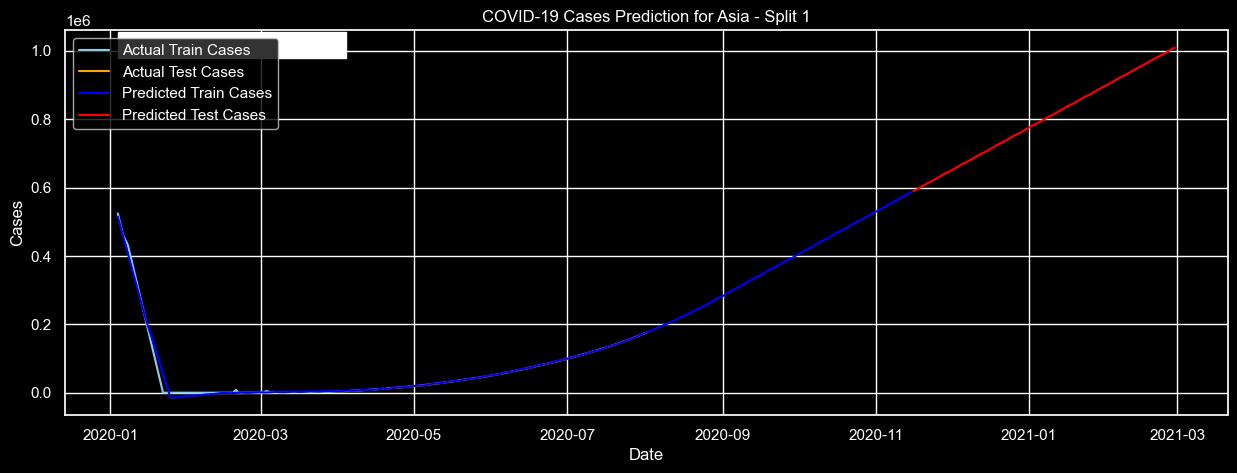

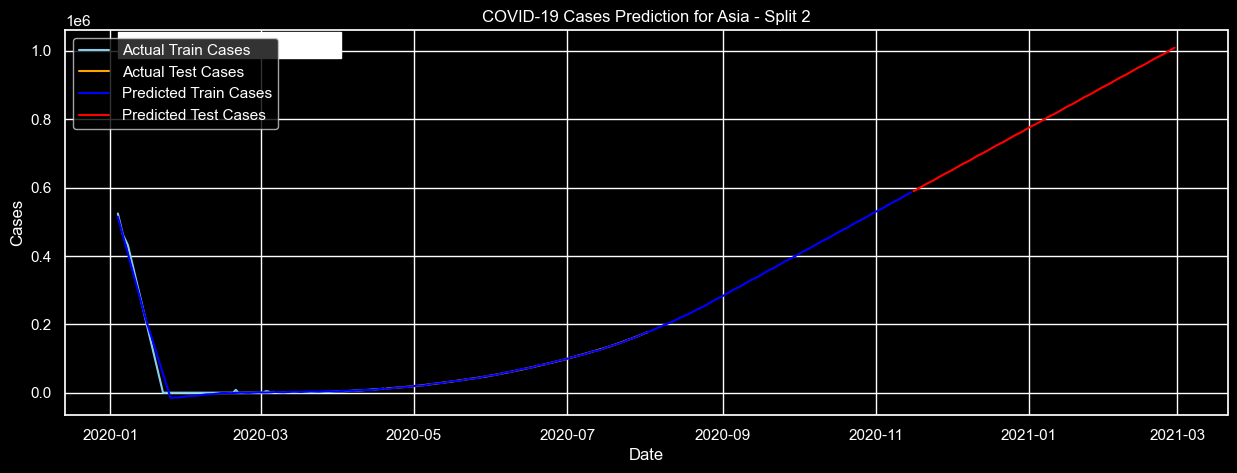

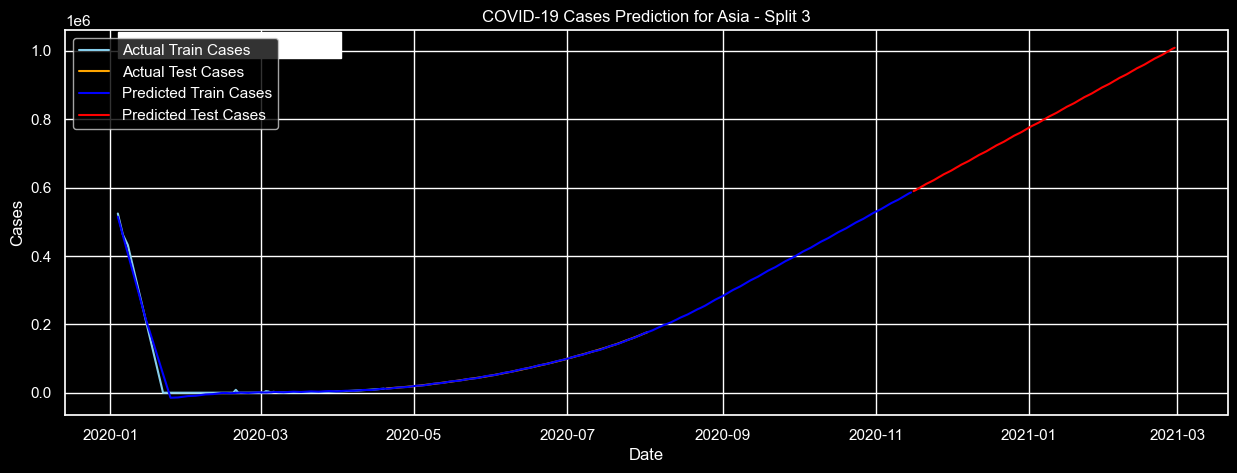

In [42]:
# visualization styles
sns.set(style="darkgrid")
plt.style.use("dark_background")

def plot_time_series_cv(predictions, scores_train, scores_test, df_dict):
    for continent in predictions.keys():
        # plotting each split
        for split_idx in range(len(scores_train[continent])):
            plt.figure(figsize=(15, 5))
            plt.title(f"COVID-19 Cases Prediction for {continent} - Split {split_idx+1}")

            # training and test data from the original dataframe
            df = df_dict[continent]
            train_idx, test_idx = next(TimeSeriesSplit(n_splits=len(scores_train[continent])).split(df))
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]

            # plots of the actual cases for training and test set
            plt.plot(train.index, train['Cases'], label='Actual Train Cases', color='skyblue')
            plt.plot(test.index, test['Cases'], label='Actual Test Cases', color='orange')
            
            # plots of predicted cases for training and test set
            plt.plot(predictions[continent]['train']['ds'], predictions[continent]['train']['yhat'], label='Predicted Train Cases', color='blue')
            plt.plot(predictions[continent]['test']['ds'], predictions[continent]['test']['yhat'], label='Predicted Test Cases', color='red')

            # we annotated the plot with the R2 score
            score_annotation = f"Train R2: {scores_train[continent][split_idx]['R2 Score']:.2f}, Test R2: {scores_test[continent][split_idx]['R2 Score']:.2f}"
            plt.annotate(score_annotation, xy=(0.05, 0.95), xycoords='axes fraction', backgroundcolor='white')

            plt.xlabel('Date')
            plt.ylabel('Cases')
            plt.legend()
            plt.show()

plot_time_series_cv(continent_predictions, evaluation_scores_train, evaluation_scores_test, df_continents)


* __Note__

    * 1e6 means 1 million // 10 to the power of 6 (1,000,000)

### ___Key Insights___

__Europe:__

* There's a noticeable overestimation during the early pandemic months, but the model adjusts and aligns closely with the actual cases in subsequent months.

__North America:__

* The predictions follow the actual trend closely in both training and testing phases for all splits.

__Asia:__

* For all splits, the test predictions maintain a consistent trend, indicating the model's stability across different time frames.

## Conclusion

The model’s predictions shows the growth of COVID-19 Cases over the month of March for each continent.

 Asia’s predicted increase is notably higher, indicating a much steeper rise in cases according to the model's forecasts.